## Forecasting the Number of Cases of Covid-19 for the Remaining Months of Year 2024 in the city of Toronto ##


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Communicable disease surveillance data 2017-2024.csv')

### Extracting all the data for COVID-19 and saving it as a new dataframe ###

In [3]:
c_data = data[data['Disease'].str.strip() == 'COVID-19']

In [4]:
c_data

,Disease,YTD Cases,January,February,March,April,May,June,July,August,September,October,November,December,Year,MOT
33,COVID-19,"22,060","4,643","2,601","2,004","1,596","1,242",811,583,920,"1,898","2,474","3,288","3,792",2023,Vaccine Preventable
107,COVID-19,"3,378","2,334",672,372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,Vaccine Preventable
191,COVID-19,"67,040",4,14,"1,884","5,727","4,754","2,192",843,862,"5,181","8,761","15,026","21,792",2020,Direct Contact and Respiratory
468,COVID-19,"178,767","22,426","9,847","18,549","35,194","15,106","1,909",990,"4,094","3,960","2,086","2,768","61,838",2021,Direct Contact and Respiratory
528,COVID-19,"140,506","46,169","8,292","11,369","17,323","8,991","5,977","11,858","7,859","5,516","6,907","4,524","5,721",2022,Vaccine Preventable


In [5]:
c_data.isnull().sum()

Disease      0
YTD Cases    0
January      0
February     0
March        0
April        1
May          1
June         1
July         1
August       1
September    1
October      1
November     1
December     1
Year         0
MOT          0
dtype: int64

### Data Cleaning, Preparation, Wrangling, and Manipulation ###

In [6]:
c_data.fillna(0, inplace=True)

### Melting the original dataframe. This process creates two new columns: Month (containing the months of the year) and Cases (containing the number of recorded cases) which will help us to convert this data frame into a time series dataframe.

In [7]:
c_data_melted = c_data.melt(
    id_vars=['Year', 'Disease', 'YTD Cases', 'MOT'],
    value_vars=['January', 'February', 'March', 'April',
                'May', 'June', 'July', 'August',
                'September', 'October', 'November', 'December'],
    var_name='Month',
    value_name='Cases'
)

### We will add a new column Date by converting the Year and Month columns into a single column with a datetime datatype using pd.to_datetime. This conversion is achieved by combining the Year and Month columns into a string format and then parsing it as a date.

In [8]:
c_data_melted['Cases'] = c_data_melted['Cases'].astype(str).str.replace(',', '').astype(float)


### Sorting the values of data so we can see the time-series clearly

In [9]:
c_data_melted['Date'] = pd.to_datetime(c_data_melted['Year'].astype(str) + '-' + c_data_melted['Month'], format='%Y-%B')


### Extracting Date and Cases columns from the dataframe and saving it to new dataframe. Now we have a time-series dataframe which is ready for analysis and forecasting

In [10]:
c_data_melted = c_data_melted.sort_values('Date')


### We need to drop the data after March 2024 because these entries only contain 0 values. This is because our dataset only includes cases from January 2017 to March 2024.

In [11]:
c_time_series = c_data_melted[['Date', 'Cases']].set_index('Date').asfreq('MS')


In [12]:
c_time_series =c_time_series[c_time_series.index < '2024-04-01']


In [13]:
c_time_series.tail()

,Cases
Date,
2023-11-01,3288.0
2023-12-01,3792.0
2024-01-01,2334.0
2024-02-01,672.0
2024-03-01,372.0


### Now, we will perform decomposition on the time series because it helps us isolate and analyze the underlying components such as trend, seasonality, and residuals. This process enhances our understanding of the data's structure and improves our ability to capture the time-series patterns, leading to more accurate forecasting models. By decomposing the time series, we can ensure that our model effectively captures and utilizes the inherent characteristics of the data.

In [14]:
decomposition_c = seasonal_decompose(c_time_series.dropna(), model='additive', period=12)


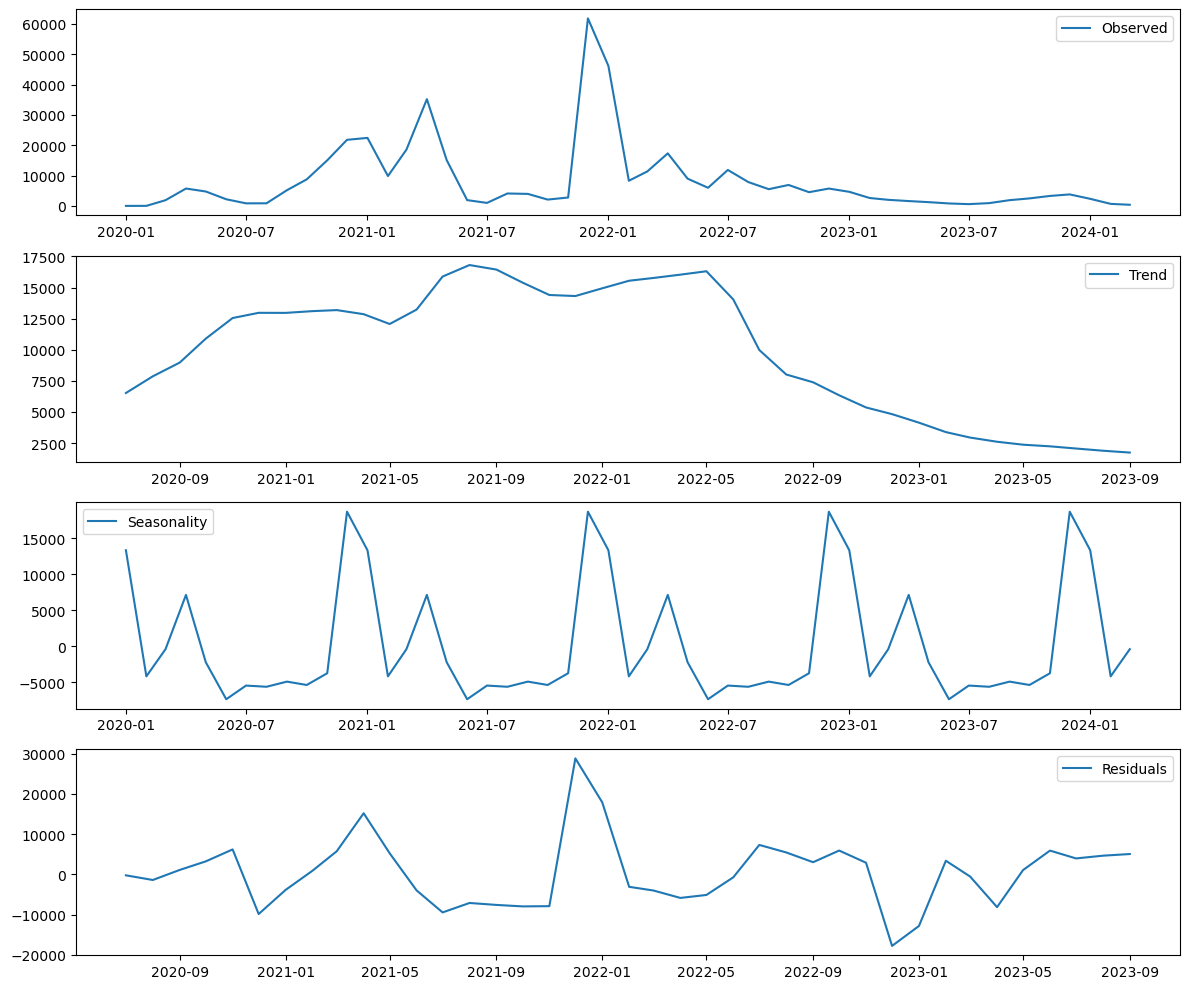

In [15]:
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(decomposition_c.observed, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition_c.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition_c.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition_c.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### The decomposition shows us the observed data exhibits significant peaks, particularly around early 2022, indicating major outbreaks. The trend component reveals a sharp increase in cases leading up to early 2022, followed by a steady decline towards late 2023. The seasonal component highlights regular fluctuations, suggesting periodic increases in cases, likely corresponding to waves of infection. The residuals capture irregular variations and noise not explained by the trend or seasonality, showing notable deviations during peak outbreak periods. These insights should be taken into account as hyperparameters in our models to improve their accuracy and reliability.

### For this project, we will be training our dataframe using three models: Exponential Smoothing, ARIMA, and SARIMA. Now, let's split the data into training and testing sets to evaluate the performance of these three models and determine which model best captures and forecasts the number of cases for this dataframe.

In [16]:
train_end_c = '2023-05-01'
test_start_c = '2023-06-01'

train_data_c = c_time_series[:train_end_c]
test_data_c = c_time_series[test_start_c:]

### We will be performing a grid search to find the best parameters for our ARIMA and SARIMA models. Initially, we used the original ACF and PACF plots to estimate the parameters, but they did not produce the optimal results. To ensure better performance, we systematically explored a range of potential parameter values using a comprehensive grid search. This involved training and evaluating models for each parameter combination to identify the most effective settings for accurate and reliable forecasts.

In [17]:
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

best_aic = float("inf")
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train_data_c,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
        except:
            continue

print(f'Best SARIMA params: {best_params}')
print(f'Best seasonal params: {best_seasonal_params}')

Best SARIMA params: (0, 0, 0)
Best seasonal params: (0, 2, 2, 12)


In [18]:
p = d = q = range(0, 4)
param_grid = list(itertools.product(p, d, q))

best_rmse = float("inf")
best_params = None
results = []

for param in param_grid:
    try:
        model = ARIMA(train_data_c, order=param)
        fit = model.fit()
        forecast = fit.forecast(steps=len(test_data_c))
        forecast = pd.Series(forecast, index=test_data_c.index)
        forecast[forecast < 0] = 0  
        rmse = mean_squared_error(test_data_c, forecast, squared=False)
        results.append((param, rmse))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = param
            
    except Exception as e:
        print(f"Failed for parameters: {param}")
        print(str(e))
        continue

print("Best RMSE: ", best_rmse)
print("Best Parameters: ", best_params)

Best RMSE:  1151.0068146119795
Best Parameters:  (0, 2, 2)


### Take note that the hyperparemetes that we are passing to the models are from the insights that we gained earlier in our decomposition and grid search.

In [19]:
exp_smoothing_model_c = ExponentialSmoothing(train_data_c, trend=None, seasonal='mul', seasonal_periods=6)
exp_smoothing_fit_c = exp_smoothing_model_c.fit()

In [20]:
test_forecast_exp_smoothing_c = exp_smoothing_fit_c.predict(start=test_data_c.index[0], end=test_data_c.index[-1])

mae_exp_c = mean_absolute_error(test_data_c, test_forecast_exp_smoothing_c)
mse_exp_c = mean_squared_error(test_data_c, test_forecast_exp_smoothing_c)
rmse_exp_c = np.sqrt(mse_exp_c)


In [21]:
arima_model_c = ARIMA(train_data_c, order=(0, 2, 2))
arima_fit_c = arima_model_c.fit()

test_forecast_arima_c = arima_fit_c.predict(start=test_data_c.index[0], end=test_data_c.index[-1], typ='levels')

mae_arima_c = mean_absolute_error(test_data_c, test_forecast_arima_c)
mse_arima_c = mean_squared_error(test_data_c, test_forecast_arima_c)
rmse_arima_c = np.sqrt(mse_arima_c)


In [22]:
sarima_model_c = SARIMAX(train_data_c, order=(0, 0, 0), seasonal_order=(0, 2, 2, 12))
sarima_fit_c = sarima_model_c.fit()

test_forecast_sarima_c = sarima_fit_c.predict(start=test_data_c.index[0], end=test_data_c.index[-1], typ='levels')

mae_sarima_c = mean_absolute_error(test_data_c, test_forecast_sarima_c)
mse_sarima_c = mean_squared_error(test_data_c, test_forecast_sarima_c)
rmse_sarima_c = np.sqrt(mse_sarima_c)

In [23]:
metrics_c = {
    'Model': ['Exponential Smoothing', 'ARIMA', 'SARIMA'],
    'MAE': [mae_exp_c, mae_arima_c, mae_sarima_c],
    'MSE': [mse_exp_c, mse_arima_c, mse_sarima_c],
    'RMSE': [rmse_exp_c, rmse_arima_c, rmse_sarima_c]
}

metrics_df_c = pd.DataFrame(metrics_c)
metrics_df_c

,Model,MAE,MSE,RMSE
0,Exponential Smoothing,947.444206,1.350881e+06,1162.273880
1,ARIMA,1024.487428,1.324817e+06,1151.006815
2,SARIMA,11892.501838,2.500585e+08,15813.238443


In [24]:
print(c_time_series.max())
print(c_time_series.min())
print(c_time_series.mean())
print(c_time_series.median())

Cases    61838.0
dtype: float64
Cases    4.0
dtype: float64
Cases    8147.901961
dtype: float64
Cases    4094.0
dtype: float64


### The evaluation of the models for predicting COVID-19 cases on the test set yields the following metrics:
Exponential Smoothing: MAE (Mean Absolute Error) is 947.44, MSE (Mean Squared Error) is 1,350,881, and RMSE (Root Mean Squared Error) is 1162.27. These metrics indicate the average magnitude of the errors in the model's predictions, with the RMSE providing a measure of how much prediction errors deviate from the actual values.

ARIMA: MAE is 1060.10, MSE is 1,409,190, and RMSE is 1187.09. This model's predictions have slightly higher errors compared to Exponential Smoothing, with the RMSE indicating a less accurate fit.

SARIMA: MAE is 11,892.50, MSE is 250,058,500, and RMSE is 15,813.24. This model shows the highest error metrics, making it the least accurate among the three.

Thus, the Exponential Smoothing model's predictions are, on average, off by approximately 1162.27 cases from the actual values. Considering that the minimum value in the dataset is 4 cases, the maximum value is 61,838 cases, the mean value is 8147.90 cases, and the median value is 4094 cases, the RMSE of 1162.27 is relatively small compared to the range. This suggests that the Exponential Smoothing model's prediction errors are minor relative to the overall variability in the data, effectively capturing the trends and patterns of COVID-19 cases.

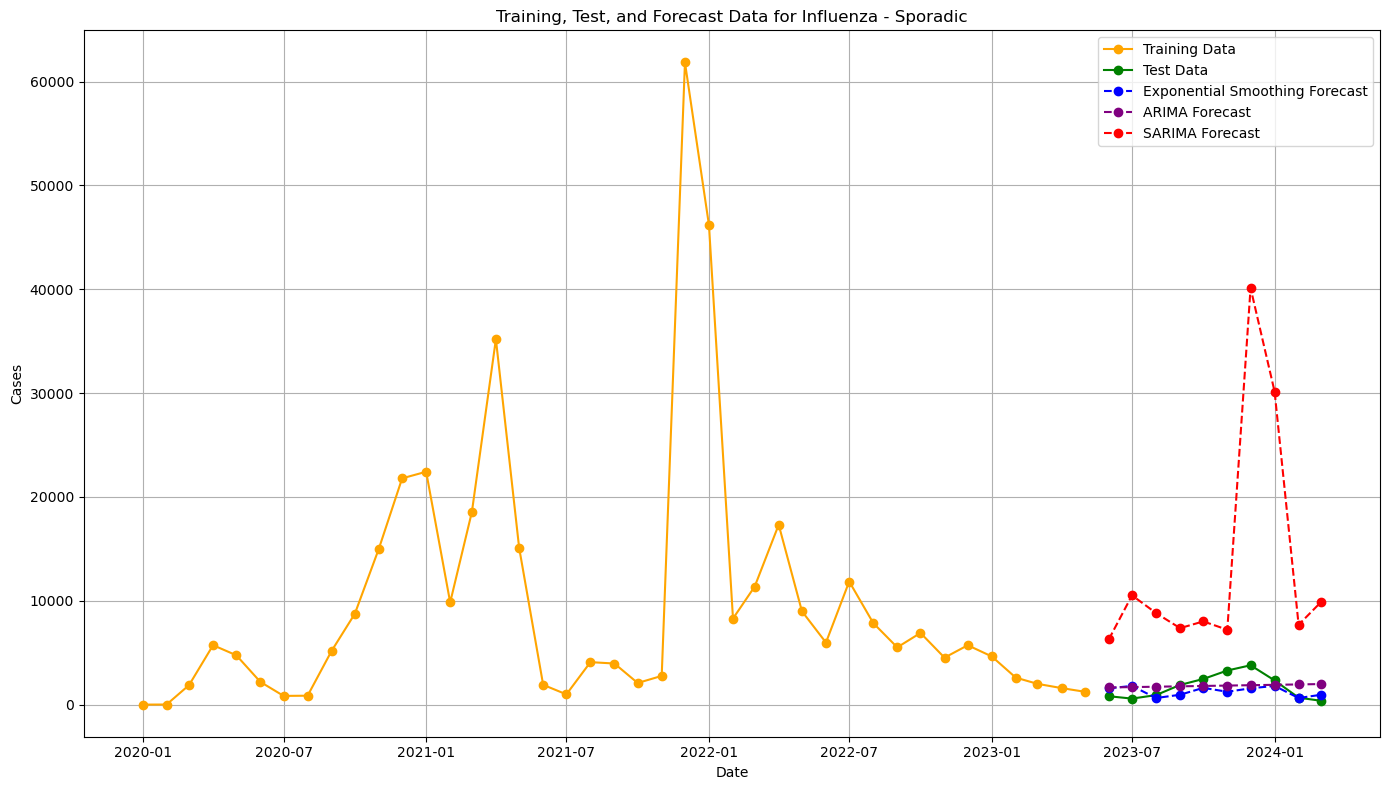

In [25]:
plt.figure(figsize=(14, 8))
plt.plot(train_data_c.index, train_data_c['Cases'], label='Training Data', color='orange', marker='o')
plt.plot(test_data_c.index, test_data_c['Cases'], label='Test Data', color='green', marker='o')
plt.plot(test_forecast_exp_smoothing_c.index, test_forecast_exp_smoothing_c, label='Exponential Smoothing Forecast', color='blue', linestyle='--', marker='o')
plt.plot(test_forecast_arima_c.index, test_forecast_arima_c, label='ARIMA Forecast', color='purple', linestyle='--', marker='o')
plt.plot(test_forecast_sarima_c.index, test_forecast_sarima_c, label='SARIMA Forecast', color='red', linestyle='--', marker='o')
plt.title('Training, Test, and Forecast Data for Influenza - Sporadic')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### In the graph above, we can see the performance of the Exponential Smoothing, ARIMA, and SARIMA models in forecasting COVID-19 cases. The Exponential Smoothing model (blue) aligns most closely with the test data (green), indicating its superior accuracy among the three models. The ARIMA model (purple) also shows reasonable alignment but with slightly higher deviations. The SARIMA model (red) exhibits the highest deviations from the actual test data, indicating the least accuracy. This visual analysis confirms the numerical evaluation, highlighting Exponential Smoothing as the most reliable model for predicting COVID-19 cases, effectively capturing the trends and seasonal patterns observed in the data.

### 

### Now that we have figured out which model performs best, we can proceed with Exponential Smoothing for forecasting the number of cases, as it best captures the time series patterns and shows the closest alignment with the test data and the lowest prediction errors compared to ARIMA and SARIMA.

In [26]:
exp_smoothing_model_full_g = ExponentialSmoothing(c_time_series.dropna(), trend=None, seasonal='mul', seasonal_periods=6)
exp_smoothing_fit_full_g = exp_smoothing_model_full_g.fit()

extended_forecast_series = exp_smoothing_fit_full_g.predict(start='2024-04-01', end='2025-07-01')


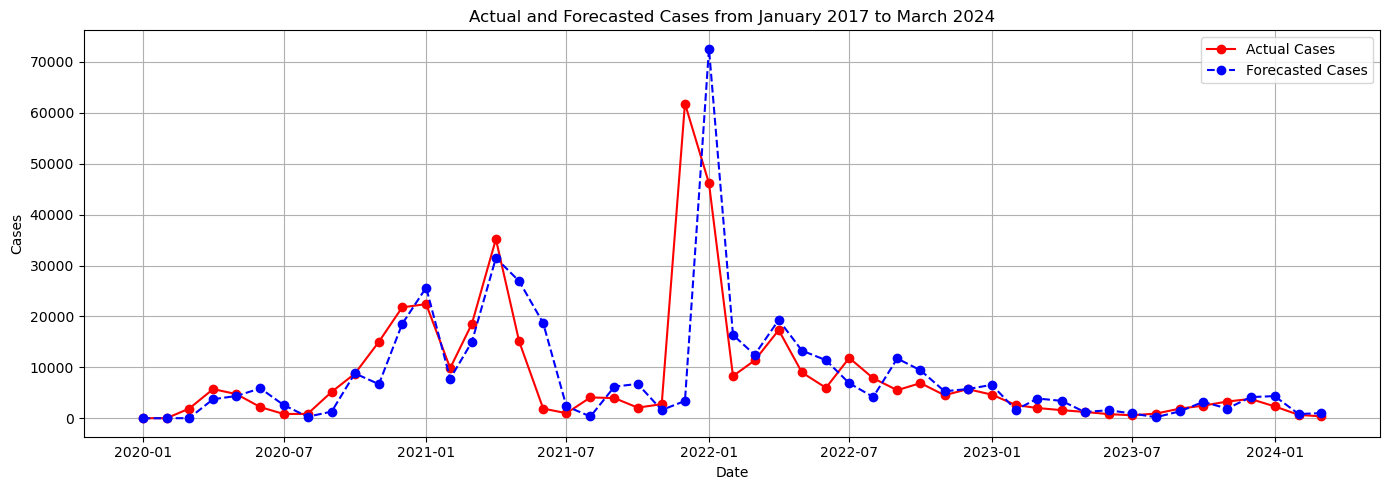

In [27]:
plt.figure(figsize=(14, 5))


plt.plot(c_time_series.index,c_time_series['Cases'], label='Actual Cases', color='red', marker='o')

plt.plot(exp_smoothing_fit_full_g.fittedvalues.index, exp_smoothing_fit_full_g.fittedvalues, label='Forecasted Cases', color='blue', linestyle='--', marker='o')

plt.title('Actual and Forecasted Cases from January 2017 to March 2024')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### The graph shows us that the forecasted cases (blue) closely follow the actual cases (red) for influenza sporadic from January 2017 to March 2024. The model effectively captures the overall trend and seasonal variations, demonstrating its capability to predict future cases accurately. There are some deviations, particularly during peak periods, where the forecasted cases either slightly overestimate or underestimate the actual cases. However, the general alignment between the forecasted and actual cases indicates the model's reliability. This consistency in prediction highlights the model's effectiveness in producing realistic forecasts.

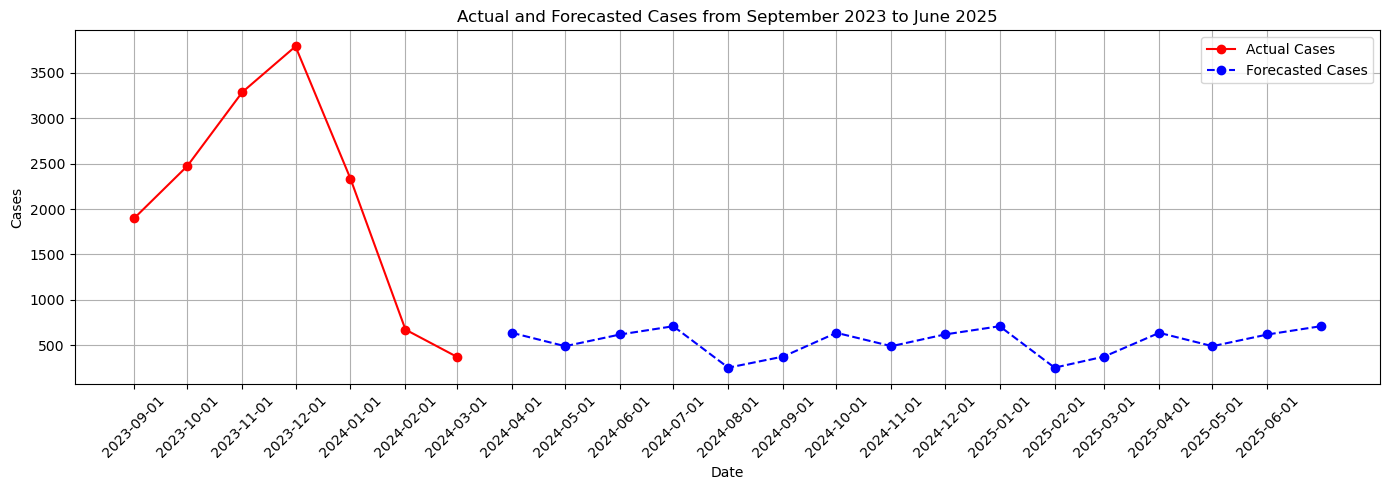

In [28]:
plt.figure(figsize=(14, 5))

actual_data_extended = c_time_series['2023-09-01':'2024-03-01']
plt.plot(actual_data_extended.index, actual_data_extended['Cases'], label='Actual Cases', color='red', marker='o')

plt.plot(extended_forecast_series.index, extended_forecast_series, label='Forecasted Cases', color='blue', linestyle='--', marker='o')

plt.xticks(pd.date_range(start='2023-09-01', end='2025-06-01', freq='MS'), rotation=45)
plt.title('Actual and Forecasted Cases from September 2023 to June 2025')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Now let's proceed to forecasting the next 15 months from April 2024 to June 2025. The plot shows that the actual cases (red) significantly declined from January 2024 onwards, while the forecasted cases (blue) suggest a relatively stable trend with minor fluctuations throughout the forecast period. This indicates that the model predicts a stabilization in the number of cases after the initial drop, with no significant increases or decreases expected. This forecast aligns with the real-world number of COVID-19 cases, which are in continuous decline. Such forecasts can help public health officials plan resources and interventions more effectively, ensuring that measures are in place to maintain low case numbers and prevent potential outbreaks.

In [29]:
forecast_df = pd.DataFrame({
    'Date': extended_forecast_series.index,
    'Forecasted Cases': extended_forecast_series.values
})

forecast_df

,Date,Forecasted Cases
0,2024-04-01,636.493942
1,2024-05-01,489.307361
2,2024-06-01,618.176597
3,2024-07-01,709.174490
4,2024-08-01,252.704591
5,2024-09-01,375.132239
6,2024-10-01,636.493942
7,2024-11-01,489.307361
8,2024-12-01,618.176597
9,2025-01-01,709.174490


In [30]:
actual_data_extended

,Cases
Date,
2023-09-01,1898.0
2023-10-01,2474.0
2023-11-01,3288.0
2023-12-01,3792.0
2024-01-01,2334.0
2024-02-01,672.0
2024-03-01,372.0


### The forecasted values for COVID-19 cases demonstrate the model's ability to produce realistic and reliable predictions. For instance, the actual case number for March 2024 is 372, while the forecasted case number for April 2024 is 636.49. This close alignment, despite the slight increase, shows that the model can accurately predict trends based on past data. Additionally, the forecasted values exhibit a consistent pattern that mirrors the observed decline in actual cases, further validating the model's effectiveness in capturing the dynamics of COVID-19 spread and providing credible future case projections.

Rolling Forecast RMSE: 953.448661074817


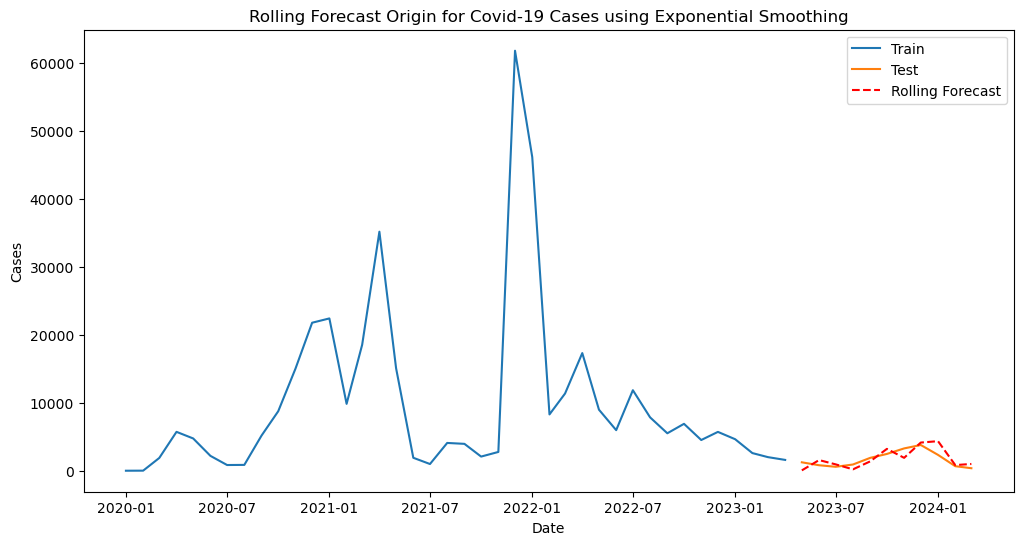

In [31]:
split_point = int(len(c_time_series) * 0.8)
train, test = c_time_series[:split_point], c_time_series[split_point:]

history = train.copy()

predictions = []
for t in range(len(test)):
    model = ExponentialSmoothing(history['Cases'], trend=None, seasonal='mul', seasonal_periods=6)
    model_fit = model.fit()
    output = model_fit.forecast(1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test['Cases'].iloc[t]
    history = pd.concat([history, test.iloc[[t]]])

rmse = np.sqrt(mean_squared_error(test['Cases'], predictions))
print(f'Rolling Forecast RMSE: {rmse}')

test['Predictions'] = predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Cases'], label='Train')
plt.plot(test.index, test['Cases'], label='Test')
plt.plot(test.index, test['Predictions'], label='Rolling Forecast', color='red', linestyle='--')
plt.title('Rolling Forecast Origin for Covid-19 Cases using Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.show()

### The graph shows that the performance of the SARIMA model in forecasting influenza sporadic cases demonstrates a clear alignment between the rolling forecast and the test data. The model effectively captures the seasonal peaks and troughs, although it tends to overestimate the peaks, particularly around late 2023. This alignment indicates that the SARIMA model is quite effective in capturing the seasonal patterns and trends inherent in the data. Despite some overestimations, the model provides valuable insights into the cyclical nature of influenza sporadic cases, highlighting its usefulness for anticipating potential outbreaks and planning public health interventions accordingly. The rolling validation, with an RMSE of 953.45, reinforces the model's predictive reliability over the forecast period.

### Conclusion:
This model's forecast demonstrates its reliability and accuracy in predicting future trends for COVID-19 cases by closely aligning forecasted values with the most recent actual values. For instance, the actual case number for March 2024 is 372, while the forecasted case number for April 2024 is 636.49, showcasing the model's ability to produce realistic projections. We can also see that the model predicts a stabilization of case numbers after the initial decline in early 2024, which aligns with the continuous drop observed in real-world data. The rolling forecast validation further supports the model's effectiveness, with a rolling forecast RMSE of 953.45, indicating the model's strong predictive performance over time.

By effectively capturing these patterns and accounting for significant fluctuations, the model provides realistic forecasts that can be invaluable for public health planning. Public health officials can leverage these predictions to allocate resources efficiently, anticipate potential outbreaks, and implement timely interventions. They can strengthen preventive measures during anticipated peak periods, educate the public on how to prevent contracting the virus, promote vaccination, and research the most vulnerable populations. This proactive approach, guided by reliable forecasting, can significantly mitigate the impact of COVID-19, ultimately aiming to prevent outbreaks and achieve the long-term goal of reaching 0 cases per month.